# Preprocessing

In [1]:
# Install openpyxl for reading excel files
# %pip install openpyxl

In [2]:
import numpy as np
import ruptures as rpt
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def calculate_scp_stats(vals):
    #sort values
    vals.sort()
    signal = np.array(vals)
    width = int(0.1 * len(signal))

    # Change point detection
    model = "l2"
    algo = rpt.Window(width=width, model=model).fit(signal)
    
    #this calculates the index, not the value
    my_bkps_idx = algo.predict(n_bkps=2)

    try:
        my_bkps = [signal[my_bkps_idx[0]], signal[my_bkps_idx[1]]]
    except IndexError:
        my_bkps = [signal[my_bkps_idx[0]], signal[-1]]

    return my_bkps

In [4]:
input_file_path = 'Lastprofilwerte_cf.xlsx'

# Read data from the input Excel file
with pd.ExcelFile(input_file_path) as input_excel:
    input_data = pd.read_excel(input_excel,skiprows=11)

# Set dtypes, names, index
input_data.rename(columns={"Datum und Uhrzeit": "datetime", "Restverbrauch (2080,882 kWh)": "usage"},inplace=True)
input_data["usage"] = input_data["usage"].astype("float")
input_data["datetime"] = pd.to_datetime(input_data["datetime"], dayfirst=False, format="%Y-%m-%d %H:%M:%S")
input_data.set_index("datetime",inplace=True)

In [5]:
# See how many values are valid -> 4 Values have been "estimated"
input_data["Status"].value_counts()
input_data.loc[input_data["Status"] == "Wert wurde geschätzt"]

,usage,Status
datetime,,
2023-02-26 00:00:00,0.135,Wert wurde geschätzt
2023-02-26 00:15:00,0.135,Wert wurde geschätzt
2023-04-19 00:00:00,0.104,Wert wurde geschätzt
2023-04-19 00:15:00,0.103,Wert wurde geschätzt


# Categorization

In [6]:
df = input_data.copy()
# General stats
# df["hour"] = df.index.hour
# df["day"] = df.index.weekday
# ax = df.groupby("hour")["usage"].mean().plot();
# df.groupby("day")["usage"].mean().plot(figsize=(20,5));
# df.groupby("hour")["usage"].min().plot();

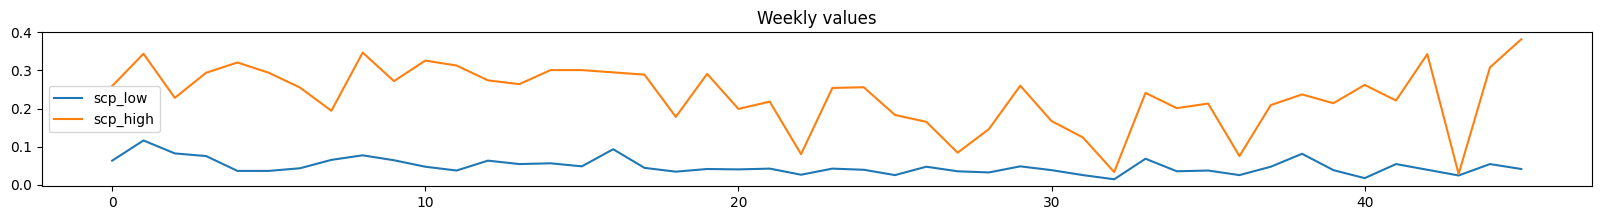

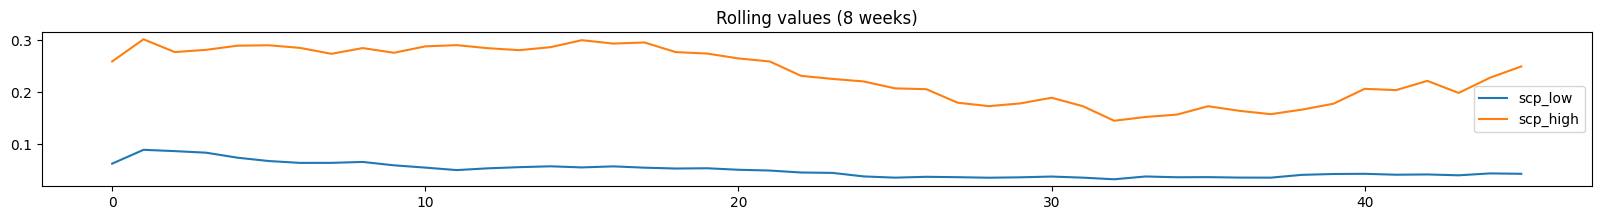

In [7]:
# add calendar week
df["week"] = df.index.isocalendar().week
weeklist = df["week"].unique()

# calculate the breakpoints
weeklybreakpoints = []
for week in weeklist:
    myvalues = df[df["week"] == week]["usage"].values
    if len(myvalues) > 400:
        breakpoints = calculate_scp_stats(myvalues)
        weeklybreakpoints.append([week]+breakpoints)

# calculate the rolling values (12 weeks)
df_bp = pd.DataFrame(weeklybreakpoints,columns=["week","scp_low","scp_high"])
#df_bp_rolling_12 = df_bp[["scp_low","scp_high"]].rolling(12,min_periods=1).mean()
df_bp_rolling_8 = df_bp[["scp_low","scp_high"]].rolling(8,min_periods=1).mean()
#df_bp_rolling_6 = df_bp[["scp_low","scp_high"]].rolling(6,min_periods=1).mean()
#df_bp_rolling_4 = df_bp[["scp_low","scp_high"]].rolling(4,min_periods=1).mean()
ax = df_bp[["scp_low","scp_high"]].plot(figsize=(20,2),title="Weekly values");
#df_bp_rolling_12.plot(figsize=(20,2),title="Rolling values (12 weeks)");
df_bp_rolling_8.plot(figsize=(20,2),title="Rolling values (8 weeks)");
#df_bp_rolling_6.plot(figsize=(20,2),title="Rolling values (6 weeks)");
#df_bp_rolling_4.plot(figsize=(20,2),title="Rolling values (4 weeks)");

# probably use 8 weeks

In [8]:
# Calculate breakpointlist
df_bp_rolling_8["week"] = df_bp["week"]
df_bp_rolling_8["validfor"] = df_bp_rolling_8["week"].shift(-1)
final_scp_bps = df_bp_rolling_8[df_bp_rolling_8["validfor"].notna()].copy()
final_scp_bps["validfor"] = final_scp_bps["validfor"].astype("int")

In [9]:
result = pd.merge(df.reset_index(),final_scp_bps,how="left",left_on=["week"], right_on=["validfor"])
result.set_index("datetime",inplace=True)
result.drop(axis="columns",labels=["Status","week_x","week_y","validfor"],inplace=True)
result

,usage,scp_low,scp_high
datetime,,,
2023-01-01 00:00:00,0.019,NaN,NaN
2023-01-01 00:15:00,0.026,NaN,NaN
2023-01-01 00:30:00,0.015,NaN,NaN
2023-01-01 00:45:00,0.019,NaN,NaN
2023-01-01 01:00:00,0.014,NaN,NaN
...,...,...,...
2023-11-18 22:45:00,0.250,0.04425,0.22775
2023-11-18 23:00:00,0.503,0.04425,0.22775
2023-11-18 23:15:00,0.081,0.04425,0.22775


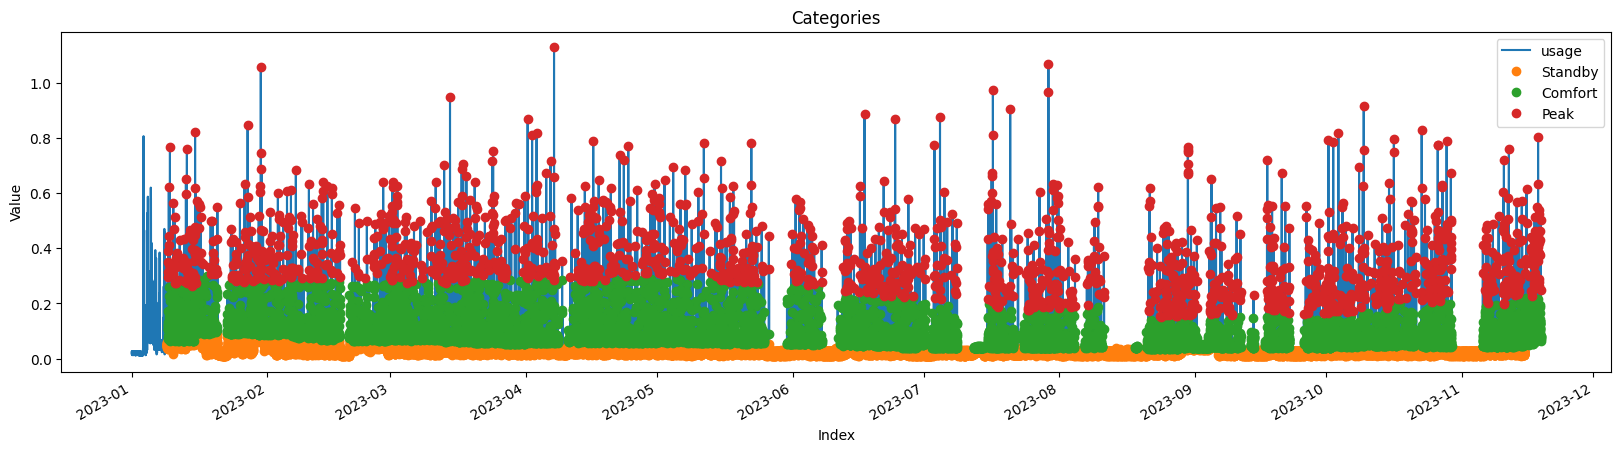

In [10]:
def get_category(val,low,high):
    cat = ""
    if val <= low:
        cat = "Standby"
    elif val <= high:
        cat = "Comfort"
    elif val > high:
        cat = "Peak"
    else:
        cat = np.nan
    return cat

result['category'] = result.apply(lambda x: get_category(x["usage"], x["scp_low"], x["scp_high"]), axis=1)
result.loc[result["category"]=="Standby","Standby"] = result["usage"]
result.loc[result["category"]=="Comfort","Comfort"] = result["usage"]
result.loc[result["category"]=="Peak","Peak"] = result["usage"]

ax = result["usage"].plot(style = "-", label="usage",figsize =(20,5))
result["Standby"].plot(style='o', ax=ax, label='Standby')
result["Comfort"].plot(style='o', ax=ax, label='Comfort')
result["Peak"].plot(style='o', ax=ax, label='Peak')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Categories')
plt.legend()

plt.show()


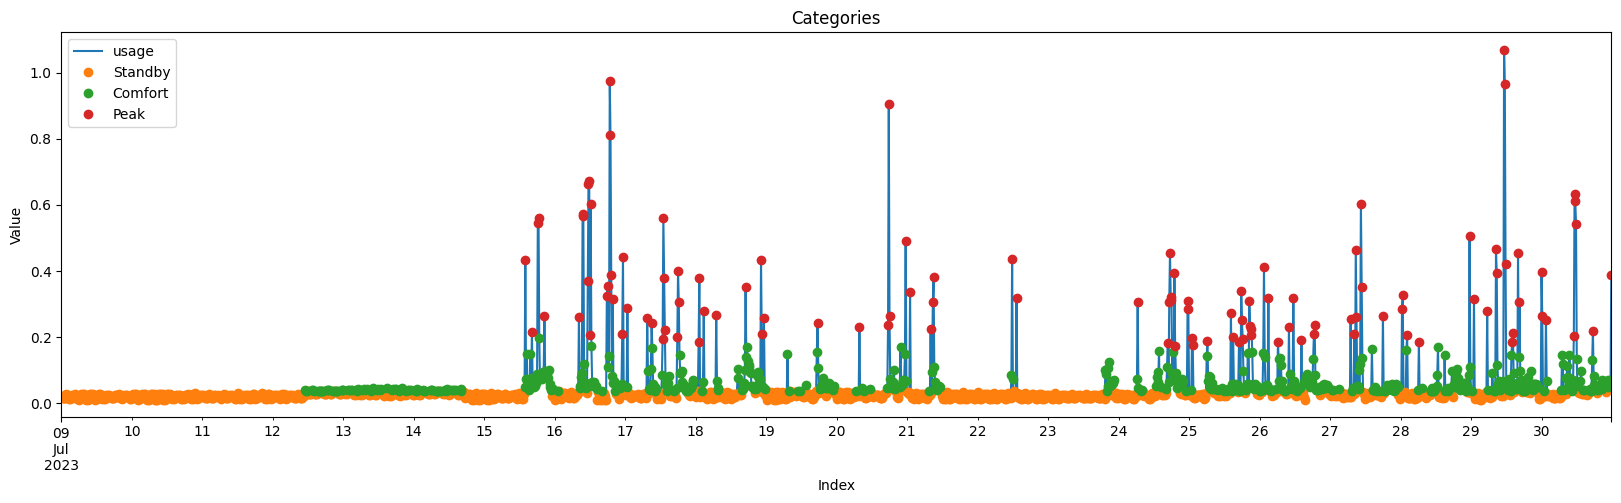

In [11]:
# Categorization weekfilter
start = "2023-07-09"
end = "2023-07-30"
ax = result["usage"][start:end].plot(style = "-", label="usage",figsize =(20,5))
result["Standby"][start:end].plot(style='o', ax=ax, label='Standby')
result["Comfort"][start:end].plot(style='o', ax=ax, label='Comfort')
result["Peak"][start:end].plot(style='o', ax=ax, label='Peak')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Categories')
plt.legend()

plt.show()

# Nighttime

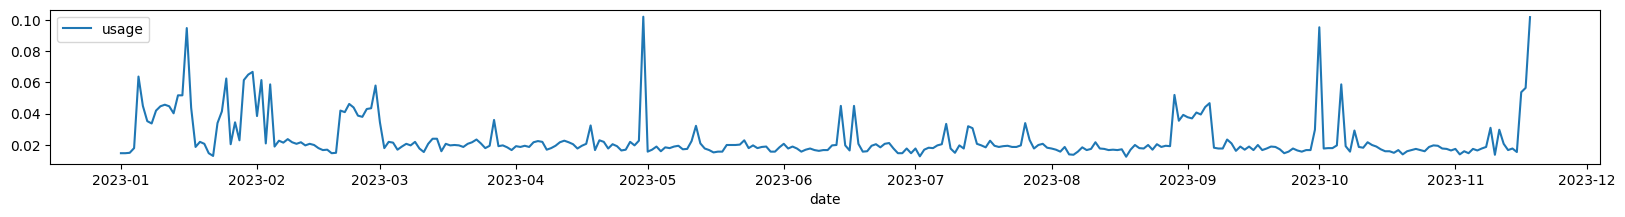

In [19]:
nightdf = result.copy()
nightdf["hour"] = nightdf.index.hour
nightdf = nightdf[(nightdf["hour"] >= 2) & (nightdf["hour"] <= 5)]
nightdf.drop(columns=["hour","scp_low","scp_high"],inplace=True)
#nightdf["2023-02-10":"2023-02-20"].plot(figsize=(20,5));
nightdf["date"] = nightdf.index.date
#nightdf[["date","usage"]].groupby(["date"]).aggregate(["min","mean","max"]).plot(figsize=(20,5))

nightdf[["date","usage"]].groupby(["date"]).quantile(0.25).plot(figsize=(20,2));

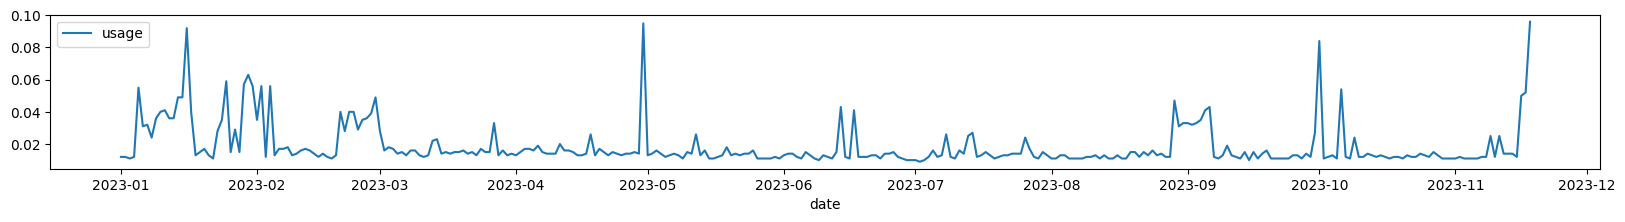

In [13]:
nightdf[["date","usage"]].groupby(["date"]).min().plot(figsize=(20,2));

<Axes: xlabel='datetime'>

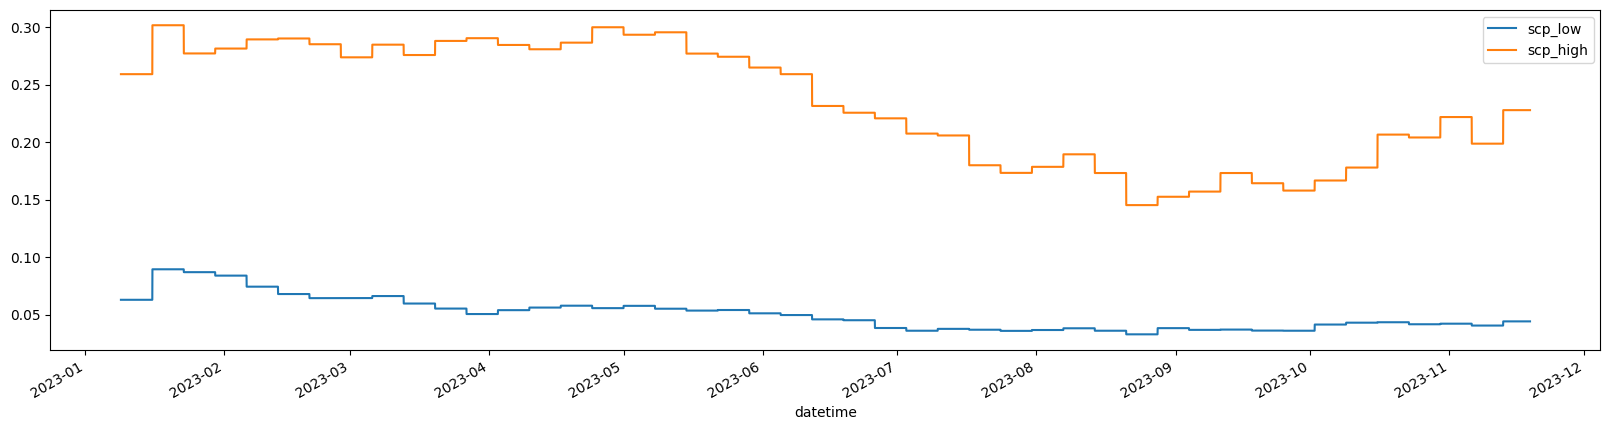

In [18]:
result[["scp_low","scp_high"]].plot(figsize=(20,5))